In [22]:
import cv2
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import numpy as np

### Test HOG

In [25]:
#reading image
img1 = cv2.imread('airplane_query.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)


Gx_img1 = cv2.Sobel(img1,cv2.CV_64F,1,0,ksize=3)
Gy_img1 = cv2.Sobel(img1,cv2.CV_64F,0,1,ksize=3)

'''
Gx_img1 = np.absolute(Gx_img1) * 255/np.max(Gx_img1)
plt.imshow(Gx_img1,cmap = plt.get_cmap('binary'))
plt.show()

Gy_img1 = np.absolute(Gy_img1) * 255/np.max(Gy_img1)
plt.imshow(Gy_img1,cmap = plt.get_cmap('binary'))
plt.show()
'''

"\nGx_img1 = np.absolute(Gx_img1) * 255/np.max(Gx_img1)\nplt.imshow(Gx_img1,cmap = plt.get_cmap('binary'))\nplt.show()\n\nGy_img1 = np.absolute(Gy_img1) * 255/np.max(Gy_img1)\nplt.imshow(Gy_img1,cmap = plt.get_cmap('binary'))\nplt.show()\n"

In [26]:
ForceGradient_img1 = np.sqrt(np.power(Gx_img1,2)+np.power(Gy_img1,2))

In [37]:
ForceGradient_img1.shape

(178, 393, 3)

In [36]:
aretes.shape

(178, 393, 3)

In [40]:
aretes = ForceGradient_img1>80
plt.imshow(aretes, plt.get_cmap('binary'))
plt.show()

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

In [41]:
FG_img1, AG_img1 = cv2.cartToPolar(Gx_img1, Gy_img1, angleInDegrees=True)

In [51]:
np.max(FG_img1)

930.6266705827853

### Test SIFT

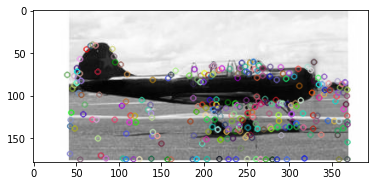

In [44]:
#reading image
img1 = cv2.imread('airplane_query.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create(	nOctaveLayers = 3, contrastThreshold=0.04,edgeThreshold = 10,sigma=1.6)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)
plt.show()

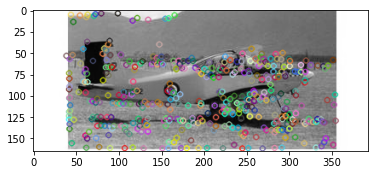

In [46]:
#reading image
img2 = cv2.imread('./database/airplane_1.jpg')  
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create(	nOctaveLayers = 3, contrastThreshold=0.04,edgeThreshold = 10,sigma=1.6)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_2 = cv2.drawKeypoints(gray2,keypoints_2,img2)
plt.imshow(img_2)
plt.show()


In [21]:
descriptors_1.shape

(295, 128)

In [20]:
descriptors_2.shape

(447, 128)

### Fonction correspondance d'image pour SIFT

In [ ]:
def correspond(descripteur_requete,descripteur_data):
    
